# Sequence to Sequence models for Blood Glucose prediction


## Intro



Seq2Seq modelling with Recurrent Neural Networks, allowing for attention mechanisim and teacher-forcing.

We pose the problem of Blood Glucose (BG) estimation with X hours in advance as a Seq2Seq auto-regressive problem. The architecture consists of:

* `ProcessInput` module: It creates embeddings for categorical variables, concatenates them with numerical ones, and pass the result through a Dense layer (this last layer being optional). Here, we could also add a block of 1-dimensional Convolutional Neural Networks, to feed subsequent modules with an enriched set of features.

* `Encoder` module: an stack of Long-short term memory (LSTM) recurrent networks, that retrieves output sequences (of length equal to the input sequences), as well as the last states.

* `Attention` module: we implement the three most used scoring functions for attention, that is, additive, general and scaled dot-product. Concerning the use of the attention vector itself, we follow [Luong et al.](https://arxiv.org/abs/1508.04025), in which the context vector is calculated for the current decoder step, and concatenated with decoder state to make the predicition. We also feed the context vector as input to the following decoding step.

* `Decoder`module: an stack of LSTM, wich may optionally use attention, as well as teacher forcing. Teacher focing is implemented with a Bernoulli random variable, that allows one to choose between prediction or ground-truth at step (t-1). If the Bernoulli probability equals 1, prediction at step (t-1) is fed to the decoder; on the contrary, if the probability is 0, it uses the ground truth. Intermediate probabilities allow one sampling between these two vectors.

  The output of the decoder may be optionally concatenated with the context vector


In our experiemnts, we do not observe any improvements when using the attention mechanism, but rather an increment in the time required for training. However, we have not extensively covered the hyper-parameter space, and thus there is room for improvement.

Regarding teacher forcing, since our task is to generate sequences without making use of the ground truth, we do observe a deterioration in the forecasting, except when using the prediciton at (t-1) to feed the decoder at step t. 


### Results

Here we show the results for Mean Absolute Error (MAE) and Mean Absolute Precentage Error (MAPE) metrics, as well as the standard deviation across all sequences in test (~40k series).

Predict BG 3 hours in advance:

  * Naive Baseline (last value in sequence):

    MAE=39.0 mg/dl, std(MAE)=29.3 mg/dl; MAPE=28.5 %, std(MAPE)=23.4 %
  * 1 day of historic data: 
  
    MAE=32.6 mg/dl, std(MAE)=21.8 mg/dl; MAPE=24.7 %, std(MAPE)=19.0 %

  * 3 day of historic data: 
    
    MAE=31.5 mg/dl, std(MAE)=20.3 mg/dl; MAPE=24.5 %, std(MAPE)=18.9 %
  * 6 day of historic data: 
  
    MAE=30.9 mg/dl, std(MAE)=20.4 mg/dl; MAPE=23.0 %, std(MAPE)=16.5 %

Predict BG 1 hour in advance:

  * Naive Baseline (last value in sequence):

    MAE=22.5 mg/dl, std(MAE)=19.9 mg/dl; MAPE=16.4 %, std(MAPE)=15.8 %

  * 1 day of historic data: 
  
    MAE=20.0 mg/dl, std(MAE)=15.7 mg/dl; MAPE=16.0 %, std(MAPE)=15.9 %
  * 3 day of historic data: 
    
    MAE=18.5 mg/dl, std(MAE)=15.1 mg/dl; MAPE=14.2 %, std(MAPE)=13.9 %
  * 6 day of historic data:

    MAE=18.3 mg/dl, std(MAE)=14.9 mg/dl; MAPE=13.9 %, std(MAPE)=13.3 %

### Bibliography


Some papers and blogs that I have followed: 


* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

* https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3

* https://www.tensorflow.org/tutorials/text/nmt_with_attention

* https://arxiv.org/pdf/1508.04025v5.pdf

* https://arxiv.org/pdf/1506.03099.pdf

* https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html

Papers trying to predict BG levels (typically, 30/60 minutes in advance):

* https://link.springer.com/content/pdf/10.1007/s41666-019-00059-y.pdf

* https://ieeexplore.ieee.org/document/8037460

* http://downloads.hindawi.com/journals/jhe/2019/8605206.pdf

* https://www.sciencedirect.com/science/article/pii/S2405959516301126 

* https://www.frontiersin.org/articles/10.3389/fams.2017.00014/full

Some interesting papers applying RNN to EHR data:

* https://arxiv.org/pdf/1711.03905.pdf 

* https://arxiv.org/pdf/1902.10877.pdf

* https://arxiv.org/abs/1511.03677

And timeseries anlysis in financial data with RNNs/attention:

* https://iopscience.iop.org/article/10.1088/1757-899X/569/5/052037/pdf

* https://arxiv.org/pdf/1902.10877.pdf

The Ohio dataset: http://smarthealth.cs.ohio.edu/bglp/OhioT1DM-dataset-paper.pdf

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
import sys
import time
import copy
import tensorflow as tf

In [0]:
from tensorflow.keras.layers import Dense, LSTM, Input, RepeatVector, concatenate
from tensorflow.keras.layers import Embedding, GaussianNoise, Reshape, Dropout 
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MAE
from tensorflow.keras.metrics import MAPE, MSE
from tensorflow.keras.backend import clear_session
from tensorflow.keras.constraints import max_norm

## Data preprocessing

### Load datasets

Each dataset consits of sequences of `history`+`future` points, with 5 features (i.e. matrices of shape=(num_sequences, `history`+`future`, 5)) : 

* time interval: days counted starting from the end of the `history` of the sequence. Thus, for points in the `history`, this feature takes negatuve values, while for points in the `future`, it's positive. 
* hour: hour of the day
* day of week: day of the week in numbers ('Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6)
* patient_id: numeric identifier for the patient, starting at zero.
* sugar level: recorded sugar level, scaled with min/max scaler.

Additionally, we add two columns for the scale (min and max) of every sequence, so that the actual shape of the datasets is (num_sequences, `history`+`future`+2, 5). The scale is thus repeated 5 times (one for each feature).

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
root = "/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/processed"
lastdate = '2020-01-28'
root = os.path.join(root, lastdate)

days = 6
hours = 1
noise = 0.0
replace = False
name = "{{dataset}}_noise_{noise}_feature-{days}days_label-{hours}hours_replace{replace}.npy" 
name = name.format(noise=noise, days=days, hours=hours, replace=replace)

history = days * 24 * 4
future = hours * 4

train = np.load(os.path.join(root, name.format(dataset='train')))
vad = np.load(os.path.join(root, name.format(dataset='vad')))
test = np.load(os.path.join(root, name.format(dataset='test')))

assert history+future+2 == train.shape[1]
assert 5 == train.shape[2]

In [0]:
np.random.seed(1203)
np.random.shuffle(train)

###  Split data 

Each input sequence has both the features and labels (x and y, if you wish), so we have to separate them.

In [0]:
def split_features_labels(data, history, future):
    """
    Method to separate historic and future events (features and labels). 
    It returns input data for the encoder and decoder, and the output data 
    for the decoder. The input data for the decoder is just the output data 
    of the decoder, shifted by one step. 

    :param data: numpy ndarray with sequences of history+future points, and 4 attributes 
      (time_interval, hour_of_day, day_of_week, patient_id, sugar_level). It has shape (?, history+future, 5)
    :param history: number of points for the features
    :param future: number of points for the labels
    :return three numpy arrays with the input data for the encoder (shape=(?, history, 5))
        and decoder (shape=(?, future+1, 1)), and the output data for the decoder
        (shape=(?, future+1, 1))
    """
    # split features and labels. Note that for the later, we only keep the 
    # feature with the sugar level, which constitutes our target
    yfeature, ylabel = data[:, :history], data[:, history:history+future, -1]
    
    # get scaler
    scaler = data[:, history+future:history+future+2, -1]
    
    # add new dimension at the end of the output arrays to the decoder
    ylabel = ylabel[:, :, np.newaxis].astype(np.float32)
    
    # add 2 new dimensions at the end of the scaler
    scaler = scaler[:, :, np.newaxis, np.newaxis]
    return yfeature, ylabel, scaler

In [0]:
train_data = split_features_labels(train, history, future)
vad_data = split_features_labels(vad, history, future)
test_data = split_features_labels(test, history, future)

In [9]:
train_data[0].shape, train_data[1].shape, train_data[2].shape

((338891, 576, 5), (338891, 4, 1), (338891, 2, 1, 1))

### Generate datasets

In [0]:
def get_columns(data):
    """
    Split and prepare input data

    :param data: array with four columns: time_interval, hour_of_day, 
        day_of_week, sugar_level
    """
    time_interval, hour_of_day, day_of_week, patient_id, sugar_level = np.split(data, 
        indices_or_sections=5, axis=2)
    # squeeze categorical features (ncessary for the Embedding layer)
    hour_of_day = np.squeeze(hour_of_day, axis=2)
    day_of_week = np.squeeze(day_of_week, axis=2)
    patient_id = np.squeeze(patient_id, axis=2)
    return (time_interval, hour_of_day, day_of_week, patient_id, sugar_level)

def get_dataset(data, batch_size, shuffle=False, drop_remainder=False):
  input_ = get_columns(data[0])
  target_ = data[1]
  scaler_ = data[2]
  buffer_size = input_[0].shape[0]

  dataset = tf.data.Dataset.from_tensor_slices((input_, target_, scaler_))
  if shuffle:
    dataset = dataset.shuffle(buffer_size)
  dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
  return dataset

In [0]:
batch_size = 100
steps_per_epoch = train_data[0].shape[0] // batch_size
train_dataset = get_dataset(train_data, batch_size, shuffle=True, drop_remainder=True) 
vad_dataset = get_dataset(vad_data, batch_size, shuffle=False, drop_remainder=False) 
test_dataset = get_dataset(test_data, batch_size, shuffle=False, drop_remainder=False) 

In [12]:
num_identifiers = np.unique(train_data[0][:, :, 3]).size
print("There are %s individuals" % num_identifiers)

There are 10 individuals


In [13]:
print("Sizes for train, vad and test are %s, %s and %s, respectively" %(train_data[0].shape[0], 
                                                                        vad_data[0].shape[0], 
                                                                        test_data[0].shape[0]))

Sizes for train, vad and test are 338891, 35288 and 37058, respectively


## Some auxiliar functions 



In [0]:
def plot_train_history(history, title, metric):
    plt.figure(figsize=(12, 6))
    loss = history[metric]
    val_loss = history['val_%s' %metric]

    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training %s' %metric)
    plt.plot(epochs, val_loss, 'r', label='Validation %s' %metric)
    plt.title(title)
    plt.legend()
    
    plt.yscale('log')
    plt.gca().grid(axis='y', which='minor')

    plt.show()

def rescale_func(y, scale):
    return scale[0] + (scale[1] - scale[0])*y

def plot_results(dataset, prediction, history, future):
    plt.figure(figsize=(12, 6))

    # get random idx
    idx = np.random.randint(0, dataset.shape[0])

    # get intervals
    xf = dataset[idx, :history, 0]
    xl = dataset[idx, history:history+future, 0]
    
    # get sequences
    input_seq_ = dataset[idx, :history, -1]
    target_seq_ = dataset[idx, history:history+future, -1]
    decoded_seq_ = np.squeeze(prediction[idx, :])
    
    # rescale: note that predictions are already rescaled
    scale = dataset[idx, history+future:history+future+2, -1]
    input_seq_ = rescale_func(input_seq_, scale)
    target_seq_ = rescale_func(target_seq_, scale)


    ymin = scale[0] - 10
    ymax = scale[1] + 10
    
    plt.plot(xf, input_seq_, '-b', markersize=2, linewidth=2, label='historic data')
    plt.plot(xl, target_seq_, '.--b', markersize=2, linewidth=2, label='future data')
    plt.plot(xl, decoded_seq_, '.--k', markersize=2, linewidth=2, label='prediction')
    plt.vlines(x=0, ymin=ymin, ymax=ymax, colors='k', linewidth=1, linestyles='--')

    plt.ylim(ymin, ymax)
    plt.xlim(-0.3-history/4/24, future/4/24+0.3)
    
    plt.ylabel('Glucose evolution (arb.units)')
    plt.xlabel('Days before/after start prediction')
    plt.legend(loc='best')

    plt.show()

## Seq2Seq model 

### Class ProcessInput 

In [0]:
class ProcessInput(tf.keras.Model):
  def __init__(self, dense_dim, dense_activation, gaussian_noise, num_ids,
               day_of_week_dim, hour_of_day_dim, patient_id_dim,
               **kwargs):
    super(ProcessInput, self).__init__(**kwargs)

    # define attribute variables
    self.dense_dim = dense_dim
    self.dense_activation = dense_activation
    self.gaussian_noise = gaussian_noise
    self.num_ids = num_ids
    self.day_of_week_dim = day_of_week_dim 
    self.hour_of_day_dim = hour_of_day_dim 
    self.patient_id_dim = patient_id_dim

    # Define embedding layers for Input categorical layers
    self.day_of_week_emb = Embedding(input_dim=7, output_dim=self.day_of_week_dim)
    self.hour_of_day_emb = Embedding(input_dim=24, output_dim=self.hour_of_day_dim)
    self.patient_id_emb = Embedding(input_dim=self.num_ids, output_dim=self.patient_id_dim)

    # gaussian noise layer 
    if self.gaussian_noise: 
      self.gn_layer = GaussianNoise(stddev=self.gaussian_noise)
    else: 
      self.gn_layer = None
    # dense layer
    if self.dense_dim: 
      # TODO use TimeDistributed before the Dense? I believe the layer is broadcasted here
      self.dense = Dense(self.dense_dim, activation=self.dense_activation)
    else:
        self.dense = None

  def call(self, inputs, training=False):
    # split inputs
    time_interval, hour_of_day, day_of_week, patient_id, sugar_level = inputs
    # create embeddings for categorical variables
    day_of_week = self.day_of_week_emb(day_of_week)
    hour_of_day = self.hour_of_day_emb(hour_of_day)
    patient_id = self.patient_id_emb(patient_id)

    # add noise
    if self.gn_layer:
        sugar_level = self.gn_layer(sugar_level, training=training)
    
    # Concatenate all inputs toghether, and pass them through a dense layer
    output = concatenate([time_interval, hour_of_day, day_of_week, 
                          patient_id, sugar_level], axis=-1)
    if self.dense:
        output = self.dense(output)
    return output

In [0]:
# simple testing
test_layer = ProcessInput(dense_dim=None, dense_activation=None, gaussian_noise=0.1, 
                          num_ids=7, day_of_week_dim=10, hour_of_day_dim=10, 
                          patient_id_dim=10)

assert test_layer.dense == None
assert test_layer.gaussian_noise == 0.1
assert test_layer.gn_layer.stddev == 0.1

out = test_layer([Input(shape=(None, 1)), Input(shape=(None,)), Input(shape=(None,)), 
                  Input(shape=(None,)), Input(shape=(None, 1))])
assert out.get_shape().as_list() == [None, None, 32]

out = test_layer([Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
                  Input(shape=(16,)), Input(shape=(16, 1))])
assert out.get_shape().as_list() == [None, 16, 32]

### Class Encoder


In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, stacked_units, kernel_mn, recurrent_mn, dropout, **kwargs):
    super(Encoder, self).__init__(**kwargs)
    self.stacked_units = stacked_units
    self.kernel_mn = kernel_mn
    self.recurrent_mn = recurrent_mn
    self.dropout = dropout

    # for loop to stack lstms, with returning sequences
    self.lstms = self.stack_lstms()

  def call(self, inputs, training=False):
    for lstm in self.lstms[:-1]:
      inputs = lstm(inputs, training=training)
    encoder_outputs, state_h, state_c = self.lstms[-1](inputs ,training=training)
    encoder_states = [state_h, state_c]  
    return encoder_outputs, encoder_states

  def stack_lstms(self):
    # for loop to stack lstms, with returning sequences
    lstms = []
    for units in self.stacked_units[:-1]:
      lstm_ = LSTM(
        units, 
        return_sequences=True, 
        kernel_constraint=max_norm(self.kernel_mn),
        recurrent_constraint=max_norm(self.recurrent_mn), 
        dropout=self.dropout)
      lstms.append(lstm_)

    # the last lstm returns the states as well as the sequences
    lstm_ = LSTM(
      self.stacked_units[-1], 
      return_state=True, 
      return_sequences=True, 
      kernel_constraint=max_norm(self.kernel_mn),
      recurrent_constraint=max_norm(self.recurrent_mn), 
      dropout=self.dropout)
    lstms.append(lstm_)
    return lstms

In [0]:
# simple testing
input_test_layer = ProcessInput(
  dense_dim=None, dense_activation=None, gaussian_noise=0.0, num_ids=7, 
  day_of_week_dim=10, hour_of_day_dim=10, patient_id_dim=10)

input_test_layer = input_test_layer(
  [Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
   Input(shape=(16,)), Input(shape=(16, 1))])

test_enc = Encoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, dropout=0.3)
enc_lstms = test_enc.lstms
assert len(enc_lstms) == 2

encoder_outputs, encoder_states = test_enc(input_test_layer)
assert len(encoder_states) == 2
assert encoder_outputs.get_shape().as_list() == [None, 16, 5]

### Attention Layer

#### Additive Attention

Bahdanau et al. https://arxiv.org/pdf/1409.0473.pdf

In [0]:
class AdditiveAttention(tf.keras.layers.Layer):
  def __init__(self, units, kernel_mn):
    super(AdditiveAttention, self).__init__()
    self.units = units
    self.kernel_mn = kernel_mn
    
    # Weights relating to target states (decoder typically)
    self.source_weight = tf.keras.layers.Dense(units, kernel_constraint=max_norm(kernel_mn))  
    # Weights relating to source states (encoder typically)
    self.target_weight = tf.keras.layers.Dense(units, kernel_constraint=max_norm(kernel_mn))  
    # score transformation
    self.score_weight = tf.keras.layers.Dense(1)  

  def call(self, inputs, training=False):
    # target is also referred as query, and source as values.
    target, source = inputs
    # target must be a hidden vector of shape=(None, hidden_size), 
    # while source has shape=(None, steps, hidden_size)

    # expand the dimension of the target, (None, 1, hidden_size)
    target_with_time_axis = tf.expand_dims(target, axis=1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.score_weight(
        tf.nn.tanh(
            self.source_weight(source) + self.target_weight(target_with_time_axis)
            )
        )

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * source
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
# simple testing
input_test_layer = ProcessInput(
  dense_dim=None, dense_activation=None, gaussian_noise=0.0, num_ids=7, 
  day_of_week_dim=10, hour_of_day_dim=10, patient_id_dim=10)

input_test_layer = input_test_layer(
  [Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
   Input(shape=(16,)), Input(shape=(16, 1))])

test_enc = Encoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, dropout=0.3)
encoder_outputs, encoder_states = test_enc(input_test_layer)
encoder_hidden = encoder_states[0]

attention_layer = AdditiveAttention(10, kernel_mn=0.2)
attention_result, attention_weights = attention_layer([encoder_hidden, encoder_outputs])

assert attention_layer.source_weight.get_input_shape_at(0) == (None, 16, 5)
assert attention_layer.source_weight.get_output_shape_at(0) == (None, 16, 10)

# why this does not work?
# attention_layer.score_weight.get_output_shape_at(0)

assert attention_result.get_shape()[1] == 5
assert attention_weights.get_shape().as_list() == [None, 16, 1]

#### General Attention

Luong et al., https://arxiv.org/pdf/1508.04025.pdf

In [0]:
class GeneralAttention(tf.keras.layers.Layer):
  def __init__(self, units, kernel_mn):
    super(GeneralAttention, self).__init__()
    self.units = units
    self.kernel_mn = kernel_mn
    
    self.score_weight = tf.keras.layers.Dense(units, kernel_constraint=max_norm(kernel_mn))  

  def call(self, inputs, training=False):
    # target is also referred as query, and source as values.
    target, source = inputs
    # target must be a hidden vector of shape=(None, hidden_size), 
    # while source has shape=(None, steps, hidden_size)

    # expand the dimension of the target, (None, 1, hidden_size)
    target_with_time_axis = tf.expand_dims(target, axis=1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are performing the dot product along that dim
    score = tf.matmul(a=target_with_time_axis, b=self.score_weight(source), transpose_b=True)
    score = tf.transpose(score, perm=[0, 2, 1])
    
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * source
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
# simple testing
input_test_layer = ProcessInput(
  dense_dim=None, dense_activation=None, gaussian_noise=0.0, num_ids=7, 
  day_of_week_dim=10, hour_of_day_dim=10, patient_id_dim=10)

input_test_layer = input_test_layer(
  [Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
   Input(shape=(16,)), Input(shape=(16, 1))])

test_enc = Encoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, dropout=0.3)
encoder_outputs, encoder_states = test_enc(input_test_layer)
encoder_hidden = encoder_states[0]

attention_layer = GeneralAttention(5, kernel_mn=0.2)
attention_result, attention_weights = attention_layer([encoder_hidden, encoder_outputs])

assert attention_layer.score_weight.get_input_shape_at(0) == (None, 16, 5)

# why this does not work?
# attention_layer.score_weight.get_output_shape_at(0)

assert attention_result.get_shape()[1] == 5
assert attention_weights.get_shape().as_list() == [None, 16, 1]

#### Scaled dot-product attention

Vaswani et al., http://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf

In [0]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(ScaledDotProductAttention, self).__init__()
    self.units = units
    self.square_root = tf.math.sqrt(tf.cast(self.units,tf.float32))

  def call(self, inputs, training=False):
    # target is also referred as query, and source as values.
    target, source = inputs
    # target must be a hidden vector of shape=(None, hidden_size), 
    # while source has shape=(None, steps, hidden_size)

    # expand the dimension of the target, (None, 1, hidden_size)
    target_with_time_axis = tf.expand_dims(target, axis=1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are performing the dot product along that dim
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are performing the dot product along that dim
    score = tf.matmul(a=target_with_time_axis, b=source, transpose_b=True)
    score = tf.divide(score, self.square_root)
    score = tf.transpose(score, perm=[0, 2, 1])
    

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * source
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
# simple testing
input_test_layer = ProcessInput(
  dense_dim=None, dense_activation=None, gaussian_noise=0.0, num_ids=7, 
  day_of_week_dim=10, hour_of_day_dim=10, patient_id_dim=10)

input_test_layer = input_test_layer(
  [Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
   Input(shape=(16,)), Input(shape=(16, 1))])

test_enc = Encoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, dropout=0.3)
encoder_outputs, encoder_states = test_enc(input_test_layer)
encoder_hidden = encoder_states[0]

attention_layer = GeneralAttention(5, kernel_mn=0.2)
attention_result, attention_weights = attention_layer([encoder_hidden, encoder_outputs])

assert attention_layer.score_weight.get_input_shape_at(0) == (None, 16, 5)

# why this does not work?
# attention_layer.score_weight.get_output_shape_at(0)

assert attention_result.get_shape()[1] == 5
assert attention_weights.get_shape().as_list() == [None, 16, 1]

### Class decoder


In [0]:
class Decoder(Encoder):
  def __init__(self, stacked_units, kernel_mn, recurrent_mn, dropout, 
               mlp_units, activation_mlp, mlp_mn, use_attention, attention_score,
               attention_kernel_mn, **kwargs):
    super(Decoder, self).__init__(stacked_units, kernel_mn, recurrent_mn, dropout, **kwargs)
    self.mlp_units = mlp_units 
    self.activation_mlp = activation_mlp
    self.mlp_mn = mlp_mn
    self.use_attention = use_attention
    self.attention_score = attention_score.lower()
    self.attention_kernel_mn = attention_kernel_mn

    self.mlp = self.mlp()
    if self.use_attention:
      if self.attention_score == 'additive':
        self.attention = AdditiveAttention(units=self.stacked_units[-1], 
                                          kernel_mn=attention_kernel_mn)
      elif self.attention_score == 'general':
        self.attention = GeneralAttention(units=self.stacked_units[-1], 
                                          kernel_mn=attention_kernel_mn)
      elif self.attention_score == 'dot-product':
        self.attention = ScaledDotProductAttention(units=self.stacked_units[-1])
      else:
        raise NotImplementedError("Attention score %s not available" %self.attention_score)

  def call(self, inputs, training=False):
    # split inputs in teacher forcing input (can be None), 
    # target states (list of decoder states at t-1),
    # source states (outputs from the encoder)
    # and context_vector from previous step (can be None)
    teacher_input, target_states_pre, source_seq, context_vector_pre = inputs
    
    # concatenate inputs from encoder and previous step (teacher forcing, context_vector)
    state_vector = context_vector_pre if self.use_attention else source_seq[:, -1, :]
    state_vector = tf.expand_dims(state_vector, 1)  # shape=(None, 1, dec_hidden_size)
    if teacher_input is not None:
      merged = tf.concat([state_vector, teacher_input], axis=-1)
    else:
      merged = state_vector
    
    # pass the merged vector through the stack of LSTMs
    # Initialize LSTM cell with target states at step t-1
    for lstm in self.lstms[:-1]:
      merged = lstm(merged, training=training, initial_state=target_states_pre)
    decoder_outputs, state_h, state_c = self.lstms[-1](merged, training=training, 
                                                       initial_state=target_states_pre)
    decoder_states = [state_h, state_c]  
    # reshape output, as we pass one step at a time
    decoder_output = tf.reshape(decoder_outputs, (-1, decoder_outputs.shape[2]))
    
    # Attention mechanism for current step
    if self.use_attention:
      target_state = decoder_states[0]
      context_vector, attention_weights = self.attention(inputs=[target_state, source_seq], 
                                                         training=training)
      concat = tf.concat([context_vector, decoder_output], axis=-1)
    else:
      concat = decoder_output
      context_vector = None

    # pass the output to the mlp. output shape=(None, 1)
    out = concat
    for dense in self.mlp:
      out = dense(out)
    return out, decoder_states, context_vector

  def mlp(self):
    # MLP for output sequences
    mlp_stack = []
    for neurons in self.mlp_units:
        decoder_dense = Dense(neurons, activation=self.activation_mlp, 
                              kernel_constraint=max_norm(self.mlp_mn))
        mlp_stack.append(decoder_dense)
    return mlp_stack

In [0]:
# simple testing
input_test_layer = ProcessInput(
  dense_dim=None, dense_activation=None, gaussian_noise=0.0, num_ids=7, 
  day_of_week_dim=10, hour_of_day_dim=10, patient_id_dim=10)

input_test_layer = input_test_layer(
  [Input(shape=(16, 1)), Input(shape=(16,)), Input(shape=(16,)), 
   Input(shape=(16,)), Input(shape=(16, 1))])

test_enc = Encoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, dropout=0.3)
encoder_outputs, encoder_states = test_enc(input_test_layer)

# test with teacher-forcing
test_dec = Decoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, 
                   dropout=0.3, mlp_units=[4, 1], activation_mlp='relu', 
                   mlp_mn=0.4, use_attention=True, attention_score='dot-product',
                   attention_kernel_mn=0.2)
input_teacher = Input(shape=(1, 1))

# initial step
# apply attention to the encoder
context_vector_enc, attention_weights = test_dec.attention([encoder_states[0], encoder_outputs])

input_dec = [input_teacher, encoder_states, encoder_outputs, context_vector_enc]
decoder_outputs, decoder_states, context_vector = test_dec(input_dec)

assert len(decoder_states) == 2
assert decoder_states[0].get_shape().as_list() == [None, 5]
assert decoder_outputs.get_shape().as_list() == [None, 1]
assert context_vector.get_shape().as_list() == [None, 5]

# subsequent steps. 
input_dec = [input_teacher, decoder_states, encoder_outputs, context_vector]
decoder_outputs, decoder_states, context_vector = test_dec(input_dec)

assert decoder_outputs.get_shape().as_list() == [None, 1]
assert context_vector.get_shape().as_list() == [None, 5]

# Finally test without teacher-forcing
test_dec = Decoder(stacked_units=[5, 5], kernel_mn=0.3, recurrent_mn=0.1, 
                   dropout=0.3, mlp_units=[4, 1], activation_mlp='relu', 
                   mlp_mn=0.4, use_attention=True, attention_score='general',
                   attention_kernel_mn=0.2)
input_teacher = None

# initial step
# apply attention to the encoder
context_vector_enc, attention_weights = test_dec.attention([encoder_states[0], encoder_outputs])

input_dec = [input_teacher, encoder_states, encoder_outputs, context_vector_enc]
decoder_outputs, decoder_states, context_vector = test_dec(input_dec)

assert len(decoder_states) == 2
assert decoder_states[0].get_shape().as_list() == [None, 5]
assert decoder_outputs.get_shape().as_list() == [None, 1]
assert context_vector.get_shape().as_list() == [None, 5]

# subsequent steps. 
input_dec = [input_teacher, decoder_states, encoder_outputs, context_vector]
decoder_outputs, decoder_states, context_vector = test_dec(input_dec)
assert decoder_outputs.get_shape().as_list() == [None, 1]
assert context_vector.get_shape().as_list() == [None, 5]


### Complete model


In [0]:
class Seq2SeqModel(tf.keras.Model):
  def __init__(self, dense_dim, dense_activation, gaussian_noise,
               num_ids, day_of_week_dim, hour_of_day_dim, patient_id_dim,
               enc_stacked_units, enc_kernel_mn, enc_recurrent_mn,
               enc_dropout, dec_stacked_units, dec_kernel_mn, dec_recurrent_mn, 
               dec_dropout, use_attention, attention_score, attention_kernel_mn, 
               mlp_units, activation_mlp, mlp_mn, 
               teacher_forcing, bernouilli_proba, 
               learning_rate, clipvalue, 
               **kwargs):
    super(Seq2SeqModel, self).__init__(**kwargs)

    # clear worksapce
    tf.keras.backend.clear_session()

    # ProcessInput parameters
    self.dense_dim = dense_dim 
    self.dense_activation = dense_activation 
    self.gaussian_noise = gaussian_noise
    self.num_ids = num_ids 
    self.day_of_week_dim = day_of_week_dim 
    self.hour_of_day_dim = hour_of_day_dim 
    self.patient_id_dim = patient_id_dim

    # Encoder Parameters
    self.enc_stacked_units = enc_stacked_units 
    self.enc_kernel_mn = enc_kernel_mn 
    self.enc_recurrent_mn = enc_recurrent_mn
    self.enc_dropout = enc_dropout 

    # Decoder parameters
    self.dec_stacked_units = dec_stacked_units 
    self.dec_kernel_mn = dec_kernel_mn 
    self.dec_recurrent_mn = dec_recurrent_mn 
    self.dec_dropout = dec_dropout 
    self.mlp_units = mlp_units 
    self.activation_mlp = activation_mlp 
    self.mlp_mn = mlp_mn 
    # attention params
    self.use_attention = use_attention
    self.attention_score = attention_score
    self.attention_kernel_mn = attention_kernel_mn

    # Optimization parameters
    self.learning_rate = learning_rate 
    self.clipvalue = clipvalue

    # Others
    self.teacher_forcing = teacher_forcing
    self.bernouilli_proba = bernouilli_proba

    # build and compile
    self.build()
    self.compile()

  def build(self):
    self.process_layer = ProcessInput(
      dense_dim=self.dense_dim, dense_activation=self.dense_activation, 
      gaussian_noise=self.gaussian_noise, num_ids=self.num_ids, 
      day_of_week_dim=self.day_of_week_dim, hour_of_day_dim=self.hour_of_day_dim, 
      patient_id_dim=self.patient_id_dim)

    self.encoder = Encoder(
      stacked_units=self.enc_stacked_units, kernel_mn=self.enc_kernel_mn, 
      recurrent_mn=self.enc_recurrent_mn, dropout=self.enc_dropout)

    self.decoder = Decoder(
      stacked_units=self.dec_stacked_units, kernel_mn=self.dec_kernel_mn, 
      recurrent_mn=self.dec_recurrent_mn, dropout=self.dec_dropout, 
      mlp_units=self.mlp_units, activation_mlp=self.activation_mlp, 
      mlp_mn=self.mlp_mn, use_attention=self.use_attention, 
      attention_score=self.attention_score, attention_kernel_mn=self.attention_kernel_mn)

  def compile(self):
    self.optimizer = tf.keras.optimizers.Adam(
      learning_rate=self.learning_rate, clipvalue=self.clipvalue)
    self.loss_function = tf.keras.losses.MeanSquaredError(name='mse')
    # we use metrcis in train and eval since MAPE cannot be aplied properly 
    # unless values are in its original scaled. 
    self.metric_train = [tf.keras.metrics.MeanAbsoluteError(name='mae')]
    self.metric_eval = [tf.keras.metrics.MeanAbsoluteError(name='mae'), 
                        tf.keras.metrics.MeanAbsolutePercentageError(name='mape')]
  @tf.function
  def train_step(self, inp, tar):
    loss = 0
    
    with tf.GradientTape() as tape:
      input_enc = self.process_layer(inp, training=True)
      enc_outputs, enc_states = self.encoder(input_enc, training=True)
      dec_states = enc_states

      # calculate context vector for last encoder state      
      if self.use_attention:
        context_vector, _ = self.decoder.attention([enc_states[0], enc_outputs])
      else:
        context_vector = None

      # provide last time step in encoder as first input char
      dec_input = tf.expand_dims(input_enc[:, -1, -1], axis=-1)
      
      for t in range(0, tar.shape[1]):
        # expand dim of dec_input
        if self.teacher_forcing:
          dec_input = tf.expand_dims(dec_input, axis=1)
        else:
          dec_input = None

        # passing enc_output to the decoder
        inputs = [dec_input, dec_states, enc_outputs, context_vector]
        predictions, dec_states, context_vector = self.decoder(inputs=inputs, training=True)

        loss += self.loss_function(tar[:, t, :], predictions)
        _ = [m.update_state(tar[:, t, :], predictions) for m in self.metric_train]
          
        # teacher-forcing with bernouilli distribution
        if self.teacher_forcing:
          p = tf.keras.backend.random_binomial(shape=(), p=self.bernouilli_proba)
          dec_input = tf.keras.backend.switch(p<0.5, tar[:, t, :], predictions)
    
    batch_loss = loss / int(tar.shape[1])
    variables = self.process_layer.trainable_variables + \
      self.encoder.trainable_variables + \
      self.decoder.trainable_variables 

    gradients = tape.gradient(loss, variables)

    self.optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

  @tf.function
  def inference_step(self, inp, steps, batch_size):

    # initialize output tensor
    prediction = []

    # forward pass through process_layer and encoder
    input_enc = self.process_layer(inp, training=False)
    enc_outputs, enc_states = self.encoder(input_enc, training=False)
    dec_states = enc_states
    
    # calculate context vector for last encoder state      
    if self.use_attention:
      context_vector, _ = self.decoder.attention([enc_states[0], enc_outputs])
    else:
      context_vector = None

    # provide last time step in encoder as first input char
    dec_input = tf.expand_dims(input_enc[:, -1, -1], axis=-1)
    
    # forward pass through the decoder
    for t in range(0, steps):
      # expand dim of dec_input
      if self.teacher_forcing:
        dec_input = tf.expand_dims(dec_input, axis=1)
      else:
        dec_input = None
      # passing enc_output to the decoder
      inputs = [dec_input, dec_states, enc_outputs, context_vector]
      step_prediction, dec_states, context_vector = self.decoder(inputs=inputs, 
                                                                 training=False)
      dec_input = step_prediction
      prediction.append(tf.expand_dims(dec_input, axis=1))
    
    # concat predictions
    prediction = tf.concat(prediction, axis=1)
    
    return prediction

  def fit_custom(self, train_dataset, epochs, vad_dataset, steps_per_epoch=None):
    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for m in self.metric_train:
      history[m.name] = []  
      history['val_%s' % (m.name)] = []  

    # steps per epoch in train and validation
    if steps_per_epoch is None:
      len_train = tf.data.experimental.cardinality(train_dataset).numpy()
    else: 
      len_train = steps_per_epoch
    len_vad = tf.data.experimental.cardinality(vad_dataset).numpy()

    for epoch in range(epochs):
    
      start = time.time()
      print('Epoch ({}/{})'.format(epoch+1, epochs))
      
      pbar = tf.keras.utils.Progbar(len_train + len_vad)

      # training loop
      loop = enumerate(train_dataset.take(len_train))

      total_loss = 0

      for (batch, (inp, targ, scaler)) in loop:
        batch_loss = self.train_step(inp, targ)
        total_loss += batch_loss
        total_metric = [(m.name, m.result()) for m in self.metric_train]
        pbar.update(batch, values=[("loss", batch_loss)] + total_metric)
      
      total_loss  /= float(len_train)
      history['loss'].append(total_loss.numpy())
      for m in self.metric_train:
        history[m.name].append(m.result().numpy())
        m.reset_states()

      # validation loop (inference and eval)
      loop = enumerate(vad_dataset)
      
      # number of steps
      batch_size, steps = [(tar.shape[0], tar.shape[1]) for inp, tar, scaler in vad_dataset.take(1)][0]
      total_loss = 0
      
      for (batch, (inp, targ, _)) in loop:
        prediction = self.inference_step(inp, steps, batch_size)
        batch_loss = self.loss_function(prediction, targ)
        total_loss += batch_loss
        # update metrics
        [m.update_state(targ, prediction) for m in self.metric_train]
        total_metric = [('val_%s' %(m.name), m.result()) for m in self.metric_train]
        # update progress bar
        pbar.update(batch, values=[("val_loss", batch_loss)] + total_metric)  
      
      total_loss  /= float(len_vad)
      history['val_loss'].append(total_loss.numpy())
      for m in self.metric_train:
        history['val_%s' %(m.name)].append(m.result().numpy())
        m.reset_states()

      print(' ({:.0f} sec)\n'.format( time.time() - start))
    return history

  @staticmethod
  def rescale_batch(y, scale):
    # shape(y) = (batch_size, steps, 1)
    # shape(scale) = (batch_size, 2, 1, 1)
    slope = scale[:, 1, :, :] - scale[:, 0, :, :]
    bias = scale[:, 0, :, :]
    return tf.math.multiply(y, slope) + bias

  def predict_evaluate_custom(self, dataset, label='test', rescale=True):
    start = time.time()

    # inference loop
    loop = enumerate(dataset)

    # number of steps (we do not perform inference for the EOS)
    batch_size, steps = [(tar.shape[0], tar.shape[1]) for inp, tar, _ in dataset.take(1)][0]

    # num steps and progress bar    
    len_ = tf.data.experimental.cardinality(dataset).numpy()
    pbar = tf.keras.utils.Progbar(len_)

    prediction = []
    for (batch, (inp, targ, scaler)) in loop:
      # prediction has shape=(batch_size, steps, 1)
      p = self.inference_step(inp, steps, batch_size)
      if rescale:
        # scale target and predicition so as to get the real mean absolute error
        targ = self.rescale_batch(scale=scaler, y=targ)
        p = self.rescale_batch(scale=scaler, y=p)
        
      # update metrics
      [m.update_state(targ, p) for m in self.metric_eval]
      total_metric = [('%s_%s' %(label, m.name), m.result()) for m in self.metric_eval]
      # update progress bar
      pbar.update(batch, values=total_metric)  
      # update total predictions
      prediction.append(p)
    
    prediction = tf.concat(prediction, axis=0).numpy()
    total_metric = [('%s_%s' %(label, m.name), m.result()) for m in self.metric_eval]
    [m.reset_states() for m in self.metric_eval]
    print(' ({:.0f} sec)\n'.format( time.time() - start))
    return prediction, total_metric

  

## Training

### Standard params

In [0]:
standard_inputs = dict(
  # ProcessInput params
  dense_dim = 80,
  dense_activation = 'selu',
  gaussian_noise = 0.0,
  num_ids = num_identifiers,
  day_of_week_dim = 20,
  hour_of_day_dim = 20,
  patient_id_dim = 20,
  # Encoder params
  enc_stacked_units = [128],
  enc_kernel_mn = 0.1,
  enc_recurrent_mn = 0.1,
  enc_dropout = 0.0,
  # Decoder params
  dec_stacked_units = [128], 
  dec_kernel_mn = 0.1,
  dec_recurrent_mn = 0.1,
  dec_dropout = 0.0,
  mlp_units = [64, 32, 16, 8, 1],
  activation_mlp = 'selu',
  mlp_mn = 0.3,
  # attention params
  use_attention = True,
  attention_kernel_mn = 0.1,
  attention_score = 'dot-product',
  # teacher forcing 
  bernouilli_proba = 1.0,
  teacher_forcing = None,
  # Optimization params
  learning_rate = 5e-4,
  clipvalue = 0.5
)

epochs = 30

### Train without attention

In [0]:
inputs = copy.deepcopy(standard_inputs)
inputs['teacher_forcing'] = False
inputs['use_attention'] = False
inputs['dense_dim'] = None

model = Seq2SeqModel(**inputs)
h = model.fit_custom(train_dataset=train_dataset, epochs=epochs, vad_dataset=vad_dataset)

plot_train_history(h, "Loss %s" %(model.loss_function), 'loss')
for metric in model.metric_train:
  plot_train_history(h, 'Metric %s' %(metric.name), metric.name)

prediction_vad, metrics_vad = model.predict_evaluate_custom(vad_dataset, 
                                                            label='vad', 
                                                            rescale=True)
for label, m in metrics_vad:
  print(label, m.numpy())

for _ in np.arange(10):
  plot_results(vad, prediction_vad, history, future)

### Teacher forcing



In [0]:
inputs = copy.deepcopy(standard_inputs)
inputs['teacher_forcing'] = True
inputs['bernouilli_proba'] = 1.0
inputs['use_attention'] = False
inputs['dense_dim'] = None

model = Seq2SeqModel(**inputs)
h = model.fit_custom(train_dataset=train_dataset, epochs=epochs, vad_dataset=vad_dataset)

plot_train_history(h, "Loss %s" %(model.loss_function), 'loss')
for metric in model.metric_train:
  plot_train_history(h, 'Metric %s' %(metric.name), metric.name)

prediction_vad, metrics_vad = model.predict_evaluate_custom(vad_dataset, 
                                                            label='vad', 
                                                            rescale=True)
for label, m in metrics_vad:
  print(label, m.numpy())

for _ in np.arange(10):
  plot_results(vad, prediction_vad, history, future)

In [0]:
inputs = copy.deepcopy(standard_inputs)
inputs['teacher_forcing'] = True
inputs['bernouilli_proba'] = 0.7
inputs['use_attention'] = False
inputs['dense_dim'] = None

model = Seq2SeqModel(**inputs)
h = model.fit_custom(train_dataset=train_dataset, epochs=epochs, vad_dataset=vad_dataset)

plot_train_history(h, "Loss %s" %(model.loss_function), 'loss')
for metric in model.metric_train:
  plot_train_history(h, 'Metric %s' %(metric.name), metric.name)

prediction_vad, metrics_vad = model.predict_evaluate_custom(vad_dataset, 
                                                            label='vad', 
                                                            rescale=True)
for label, m in metrics_vad:
  print(label, m.numpy())

for _ in np.arange(10):
  plot_results(vad, prediction_vad, history, future)

### Train with attention

Here we recommend using teacher forcing to speed up computation (models with attention take for ages!). Since during inference the model does't see true targets, we recommend setting the `bernouilli_proba` param above 0.5 (so that more predicitons than true targets are passed to the next time step while training).

In [0]:
inputs = copy.deepcopy(standard_inputs)
inputs['teacher_forcing'] = False
inputs['use_attention'] = True
inputs['attention_score'] = 'dot-product'
inputs['dense_dim'] = None

model = Seq2SeqModel(**inputs)
h = model.fit_custom(train_dataset=train_dataset, epochs=epochs, vad_dataset=vad_dataset)

plot_train_history(h, "Loss %s" %(model.loss_function), 'loss')
for metric in model.metric_train:
  plot_train_history(h, 'Metric %s' %(metric.name), metric.name)

prediction_vad, metrics_vad = model.predict_evaluate_custom(vad_dataset, 
                                                            label='vad', 
                                                            rescale=True)
for label, m in metrics_vad:
  print(label, m.numpy())

for _ in np.arange(10):
  plot_results(vad, prediction_vad, history, future)

In [0]:
inputs = copy.deepcopy(standard_inputs)
inputs['teacher_forcing'] = True
inputs['bernouilli_proba'] = 0.8
inputs['use_attention'] = True
inputs['attention_score'] = 'dot-product'
inputs['dense_dim'] = None

model = Seq2SeqModel(**inputs)
h = model.fit_custom(train_dataset=train_dataset, epochs=epochs, vad_dataset=vad_dataset)

plot_train_history(h, "Loss %s" %(model.loss_function), 'loss')
for metric in model.metric_train:
  plot_train_history(h, 'Metric %s' %(metric.name), metric.name)

prediction_vad, metrics_vad = model.predict_evaluate_custom(vad_dataset, 
                                                            label='vad', 
                                                            rescale=True)
for label, m in metrics_vad:
  print(label, m.numpy())

for _ in np.arange(10):
  plot_results(vad, prediction_vad, history, future)

### Results with best model

Epoch (1/40)
 352/3741 [=>............................] - ETA: 32:25 - loss: 0.0149 - mae: 0.0990 - val_loss: 0.0140 - val_mae: 0.0917 (202 sec)

Epoch (2/40)
 351/3741 [=>............................] - ETA: 30:06 - loss: 0.0120 - mae: 0.0777 - val_loss: 0.0112 - val_mae: 0.0794 (187 sec)

Epoch (3/40)
 352/3741 [=>............................] - ETA: 30:03 - loss: 0.0112 - mae: 0.0740 - val_loss: 0.0115 - val_mae: 0.0802 (187 sec)

Epoch (4/40)
 350/3741 [=>............................] - ETA: 30:15 - loss: 0.0108 - mae: 0.0721 - val_loss: 0.0109 - val_mae: 0.0804 (187 sec)

Epoch (5/40)
 351/3741 [=>............................] - ETA: 30:13 - loss: 0.0107 - mae: 0.0714 - val_loss: 0.0109 - val_mae: 0.0781 (188 sec)

Epoch (6/40)
 351/3741 [=>............................] - ETA: 30:14 - loss: 0.0106 - mae: 0.0705 - val_loss: 0.0106 - val_mae: 0.0789 (188 sec)

Epoch (7/40)
 351/3741 [=>............................] - ETA: 30:14 - loss: 0.0105 - mae: 0.0703 - val_loss: 0.0104 - val_m

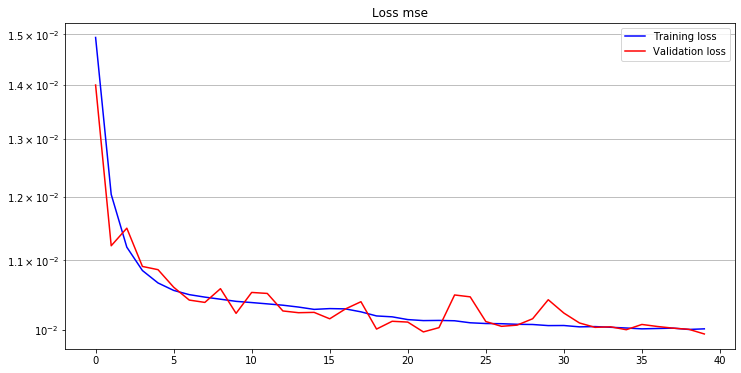

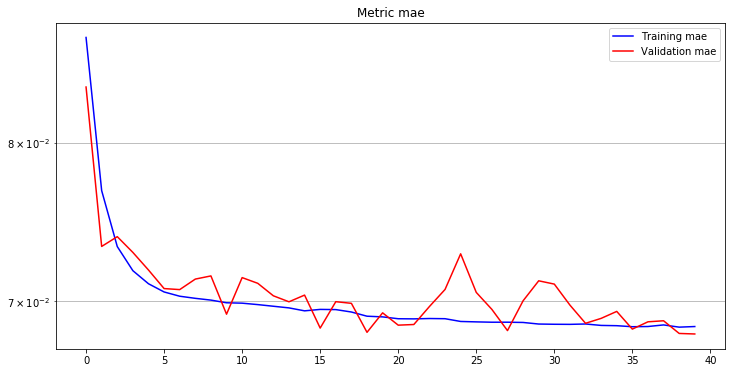

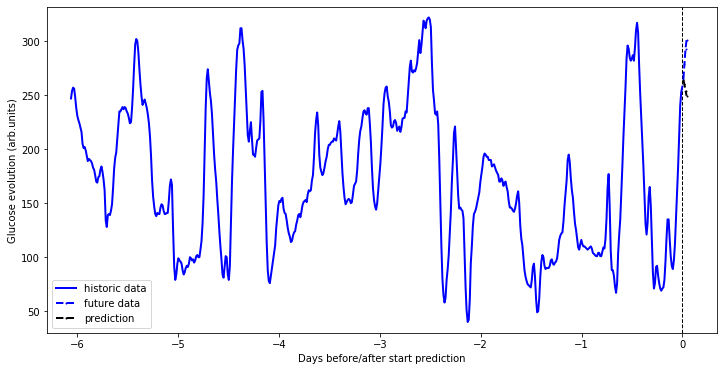

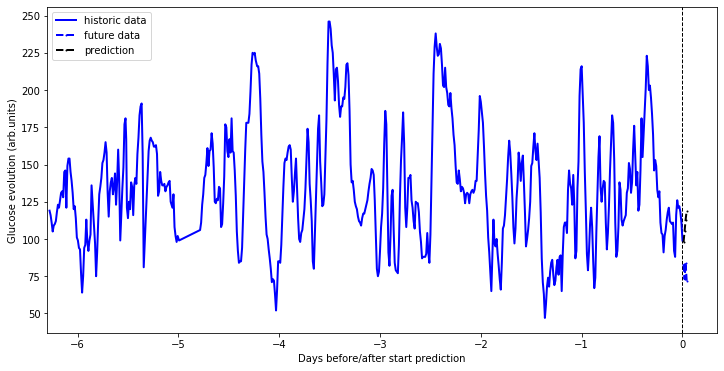

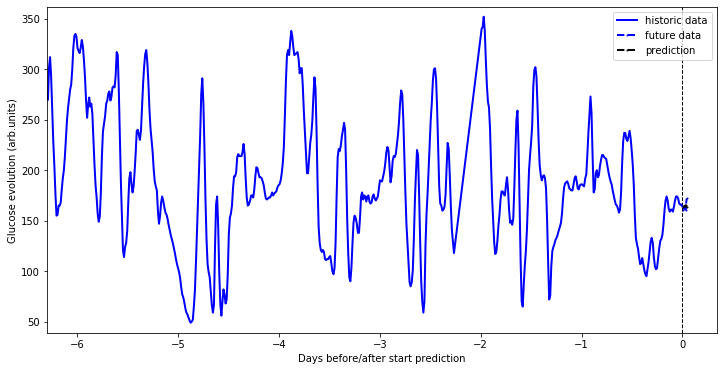

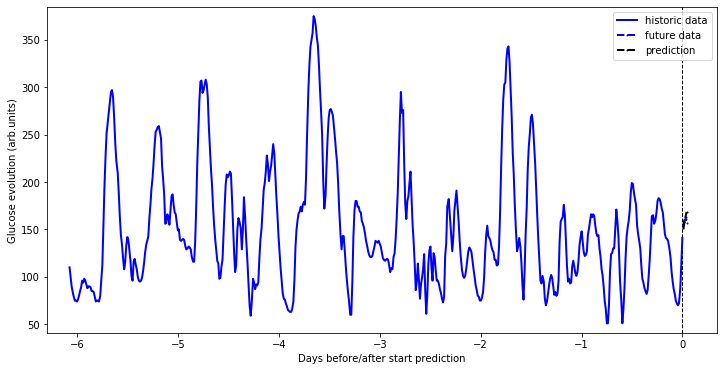

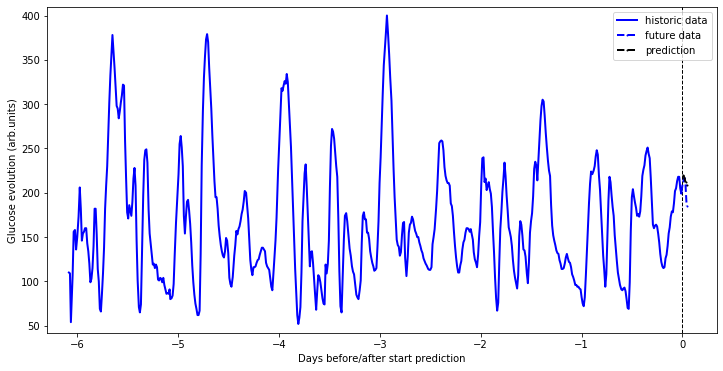

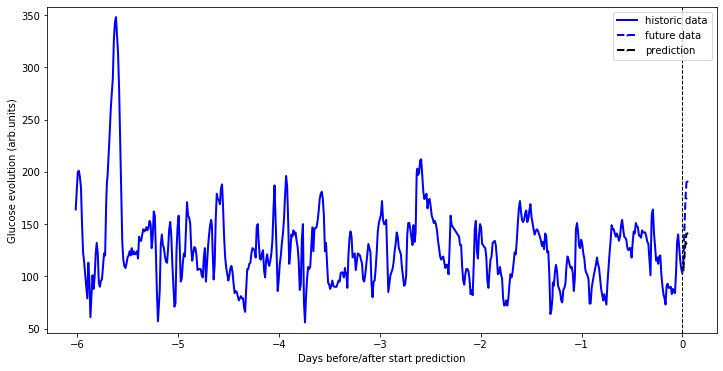

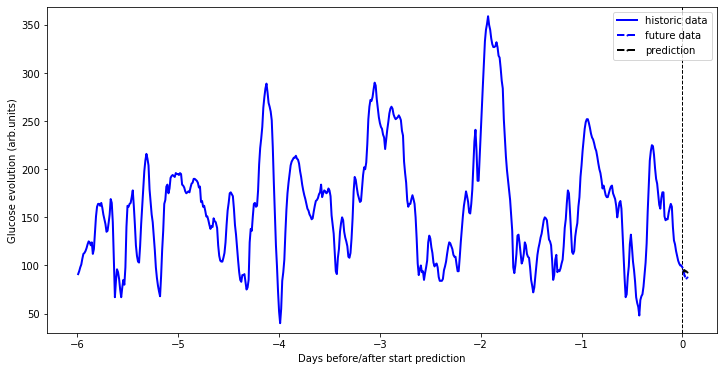

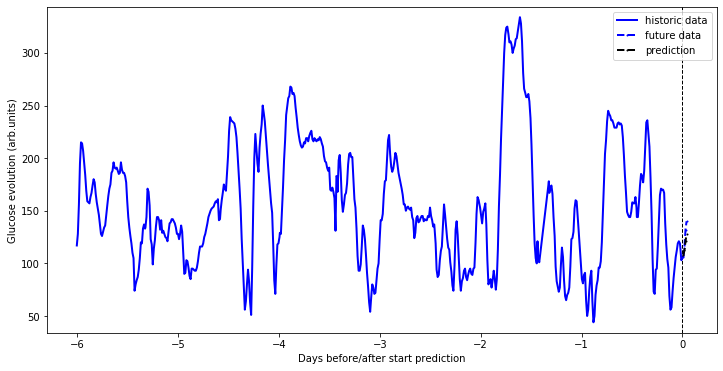

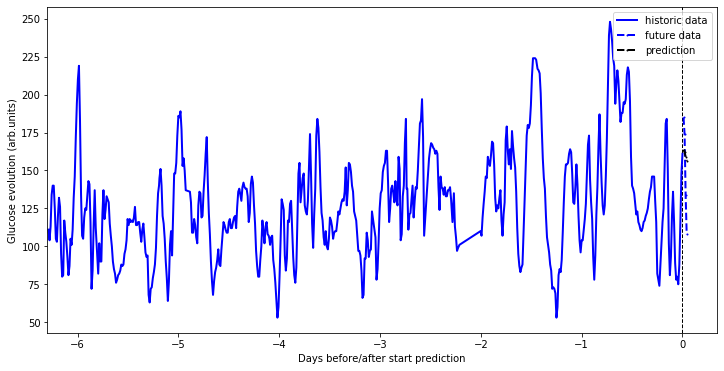

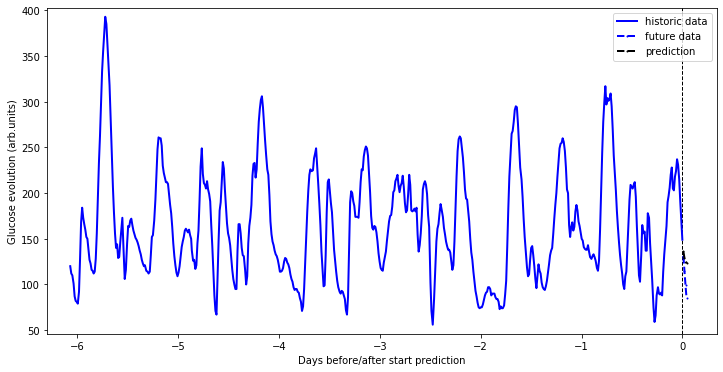

Mean Absolute Error in test is 18.3019 mg/dl)
Mean Absolute Percentage Error in test is 13.9498 %


In [29]:
inputs = copy.deepcopy(standard_inputs)
inputs['teacher_forcing'] = False
inputs['use_attention'] = False
inputs['dense_dim'] = None

epochs = 40

model = Seq2SeqModel(**inputs)
h = model.fit_custom(train_dataset=train_dataset, epochs=epochs, vad_dataset=vad_dataset)
prediction, metrics = model.predict_evaluate_custom(test_dataset, label='test', 
                                                    rescale=True)
plot_train_history(h, "Loss %s" %(model.loss_function.name), 'loss')
for metric in model.metric_train:
  plot_train_history(h, 'Metric %s' %(metric.name), metric.name)

for _ in np.arange(10):
  plot_results(test, prediction, history, future)

mae = [v for l, v in metrics if 'mae' in l][0].numpy()
mape = [v for l, v in metrics if 'mape' in l][0].numpy()

print("Mean Absolute Error in test is %.4f mg/dl)" % mae)
print("Mean Absolute Percentage Error in test is %.4f %%" % mape)

#### Simple analysis of the metrics

In [30]:
scaler = test_data[2]
ylabel = test_data[1]
ids_ = test_data[0][:, 0, 3]
ground_truth = scaler[:, 0, :, :] + np.multiply(scaler[:, 1, :, :] - scaler[:, 0, :, :], ylabel)

ground_truth = np.squeeze(ground_truth)
prediction = np.squeeze(prediction)

df = pd.DataFrame({'id': ids_, 'target': ground_truth.tolist(), 'pred': prediction.tolist()})

df['mae'] = df.apply(lambda r: np.mean(abs(np.array(r['target']) - np.array(r['pred']))) ,axis=1)
df['mape'] = df.apply(lambda r: 100.0 * np.mean(abs((np.array(r['target']) - np.array(r['pred']))/np.array(r['target']))),axis=1)
df.head()

,id,target,pred,mae,mape
0,8.0,"[167.0, 137.0, 132.0, 155.0]","[202.13438415527344, 195.45635986328125, 186.9...",43.018547,30.130689
1,8.0,"[88.0, 82.0, 87.0, 96.0]","[95.61006164550781, 100.67631530761719, 106.74...",15.525970,17.715371
2,8.0,"[90.0, 83.0, 87.0, 88.0]","[101.00801086425781, 102.96385955810547, 106.9...",18.275789,21.105091
3,8.0,"[77.0, 75.0, 68.0, 67.0]","[74.74829864501953, 84.98651885986328, 93.4559...",17.860149,26.010667
4,8.0,"[189.0, 177.0, 153.0, 158.0]","[176.15150451660156, 166.08432006835938, 155.7...",9.291222,5.375908


Mean Absolute Error in test is 18.3019 +- 14.9440 (mg/dl)
Mean Absolute Percentage Error in test is 13.9498 +- 13.3357(%)


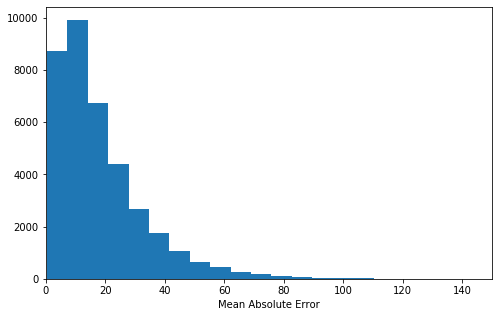

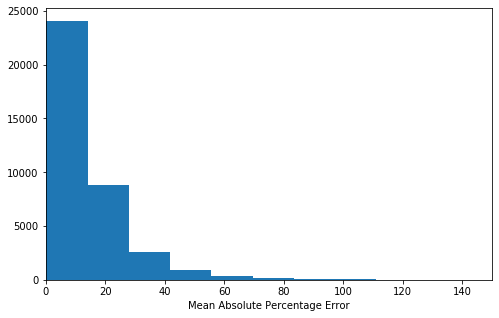

In [31]:
mae_stats = df.mae.values
mape_stats = df.mape.values

plt.figure(figsize=(8, 5))
plt.hist(mae_stats, bins=20)
plt.xlabel('Mean Absolute Error')
plt.xlim([0, 150])

plt.figure(figsize=(8, 5))
plt.hist(mape_stats, bins=20)
plt.xlabel('Mean Absolute Percentage Error')
plt.xlim([0, 150])

print("Mean Absolute Error in test is %.4f +- %.4f (mg/dl)" % (np.mean(mae_stats), np.std(mae_stats)))
print("Mean Absolute Percentage Error in test is %.4f +- %.4f(%%)" % (np.mean(mape_stats), np.std(mape_stats)))

In [32]:
df_ind = df.groupby('id')['mae', 'mape'].agg({'mae': ['median', 'mean', 'std'], 'mape': ['median', 'mean', 'std']})
df_ind

mae                             mape                      
        median       mean        std     median       mean        std
id                                                                   
0.0  14.210394  19.666061  16.834322   8.315553  12.744121  13.750151
1.0  13.335752  18.365492  15.973626  12.447822  16.390724  14.209175
2.0  11.916496  16.927427  14.516153   7.959155  11.120430   9.665785
3.0  17.612556  22.404271  17.627406  12.196780  16.662928  15.655245
4.0  11.861871  14.900755  10.612057  10.240994  15.568731  15.301429
5.0  11.838604  15.713946  12.764585   8.230388  12.058452  12.139374
6.0   9.352953  11.940715   9.273451   7.826739  10.394292   9.093021
7.0  14.078892  18.517167  15.257504   8.424371  11.326309   9.244558
8.0  15.171310  18.006356  12.359910  12.394577  16.036393  12.860881
9.0  10.700447  13.843122  11.093278   7.585976  10.063185   8.919750

#### Naive baseline

Use BS at last time-step in features to make the prediction

In [33]:
scaler = test_data[2]
ylabel = test_data[0][:, -1, -1]
ylabel = ylabel[:, np.newaxis, np.newaxis]
prediction_base = scaler[:, 0, :, :] + np.multiply(scaler[:, 1, :, :] - scaler[:, 0, :, :], ylabel)

prediction_base = np.squeeze(prediction_base)
print(ground_truth.shape, prediction_base.shape)
df_base = pd.DataFrame({'id': ids_, 'target': ground_truth.tolist(), 'pred': prediction_base})

df_base['mae'] = df_base.apply(lambda r: np.mean(abs(np.array(r['target']) - r['pred'])) ,axis=1)
df_base['mape'] = df_base.apply(lambda r: 100.0 * np.mean(abs((np.array(r['target']) - r['pred'])/np.array(r['target']))),axis=1)
df_base.head()

(37058, 4) (37058,)


,id,target,pred,mae,mape
0,8.0,"[167.0, 137.0, 132.0, 155.0]",201.0,53.25,37.256189
1,8.0,"[88.0, 82.0, 87.0, 96.0]",101.0,12.75,14.810937
2,8.0,"[90.0, 83.0, 87.0, 88.0]",101.0,14.00,16.193413
3,8.0,"[77.0, 75.0, 68.0, 67.0]",78.0,6.25,9.105624
4,8.0,"[189.0, 177.0, 153.0, 158.0]",185.0,17.75,11.159954


Mean Absolute Error in test is 22.5227 +- 19.8757 (mg/dl)
Mean Absolute Percentage Error in test is 16.4479 +- 15.8474(%)


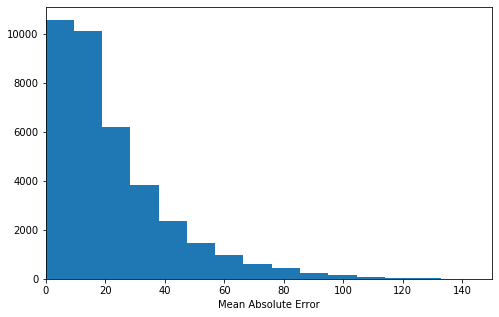

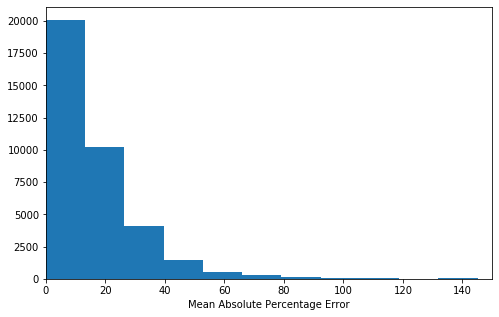

In [34]:
mae_stats = df_base.mae.values
mape_stats = df_base.mape.values

plt.figure(figsize=(8, 5))
plt.hist(mae_stats, bins=20)
plt.xlabel('Mean Absolute Error')
plt.xlim([0, 150])

plt.figure(figsize=(8, 5))
plt.hist(mape_stats, bins=20)
plt.xlabel('Mean Absolute Percentage Error')
plt.xlim([0, 150])

print("Mean Absolute Error in test is %.4f +- %.4f (mg/dl)" % (np.mean(mae_stats), np.std(mae_stats)))
print("Mean Absolute Percentage Error in test is %.4f +- %.4f(%%)" % (np.mean(mape_stats), np.std(mape_stats)))

In [35]:
df_base_ind = df_base.groupby('id')['mae', 'mape'].agg({'mae': ['median', 'mean', 'std'], 'mape': ['median', 'mean', 'std']})
df_base_ind

mae                             mape                      
     median       mean        std     median       mean        std
id                                                                
0.0  18.500  25.907330  23.599543  10.556922  16.947353  20.051833
1.0  15.500  22.174667  21.201191  14.136208  19.485872  20.393961
2.0  15.000  20.777183  18.353286   9.799141  12.989491  12.258986
3.0  22.000  29.195611  23.566116  15.862983  20.400852  17.550290
4.0  12.125  14.380297  10.526952  10.270833  14.128796  13.025544
5.0  15.000  19.588867  16.234610  10.519403  14.647489  13.563977
6.0   9.750  13.229104  10.984132   8.439787  11.232852   9.755090
7.0  11.750  19.046369  19.253797   7.382273  11.220771  10.623892
8.0  15.750  19.968509  15.474306  13.212413  16.913674  13.529239
9.0  13.000  16.347303  12.819676   9.197823  11.410899   8.989372